# Multilevel modeling

In [250]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)

library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [174]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))

In [175]:
df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

df[, le_log := scale(log(le), scale=FALSE)]
df[, gdp_log := scale(log(gdp), scale=FALSE)]
df[, year_log := scale(log(year), scale=FALSE)]

In [176]:
head(df)

ctry,year,gdp,le,le_log,gdp_log,year_log
2020,1900,2875.352,41.14719,-0.2832005,-0.0001331202,-0.03272400
2020,1905,3478.617,36.49913,-0.4030676,0.1903267151,-0.03009587
2020,1910,3821.710,41.14719,-0.2832005,0.2843900144,-0.02747464
2020,1915,3243.723,38.29062,-0.3551511,0.1204137191,-0.02486026
2020,1920,3473.069,39.97605,-0.3120756,0.1887304573,-0.02225270
2020,1925,3919.410,41.77955,-0.2679491,0.3096329779,-0.01965191


## Multilevel model

In [4]:
# how many countries
length(unique(df$ctry))

[1] 19

I centered the variables to facilitate estimation. 

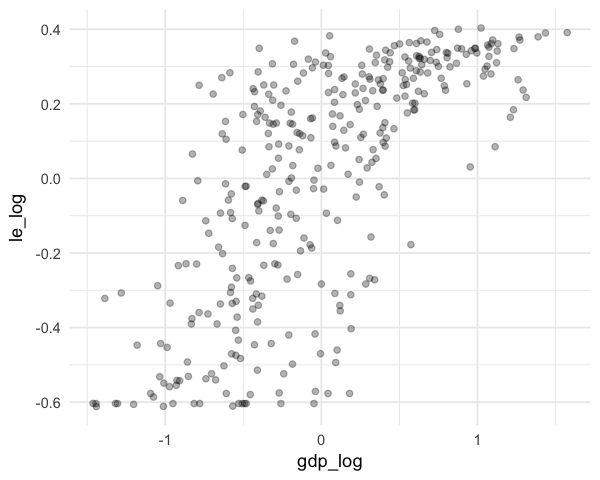

In [123]:
ggplot(df, aes(y=le_log, x=gdp_log)) + geom_point(alpha=0.3) + theme_minimal()

## Descriptives plots by country

### LE and GDP (logs)

Not always linear.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


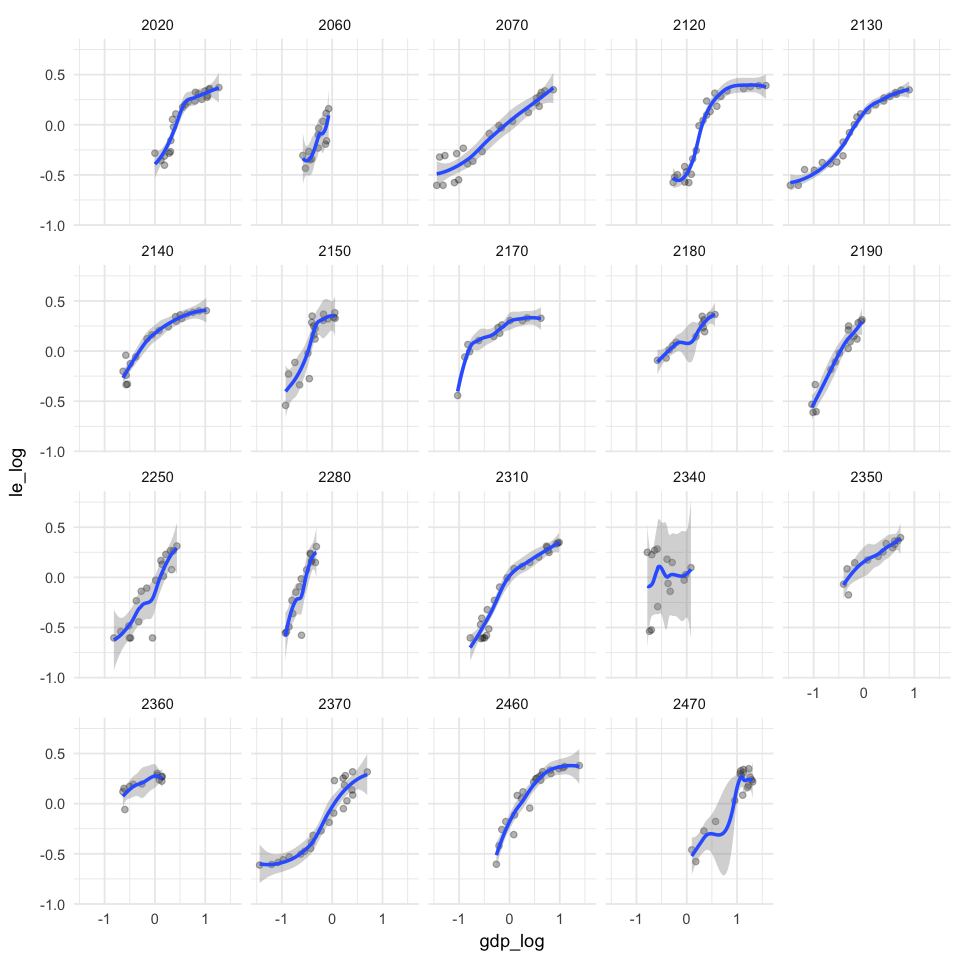

In [128]:
options(repr.plot.width = 8, repr.plot.height = 8)
p = ggplot(data = df, aes(x = gdp_log, y = le_log)) + geom_point(alpha=0.3) + geom_smooth() + theme_minimal()
p + facet_wrap(~ctry)

### LE and time

Far from linear!

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


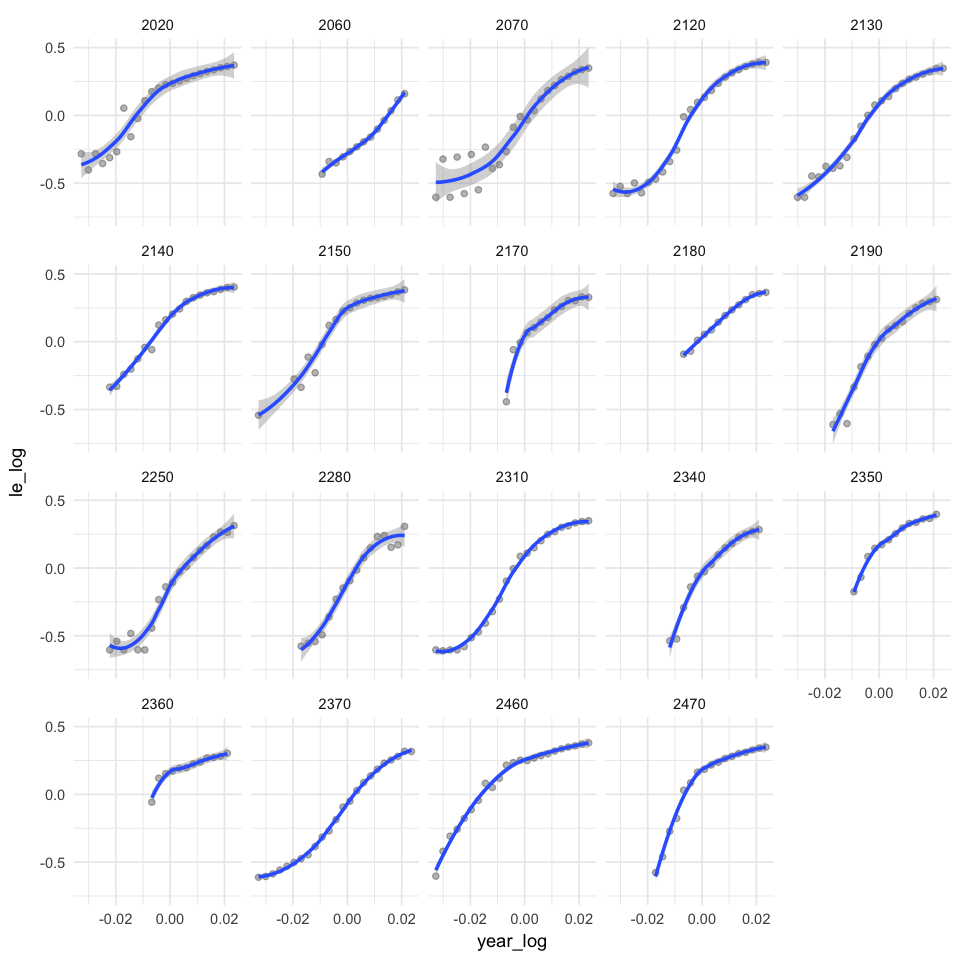

In [177]:
options(repr.plot.width = 8, repr.plot.height = 8)
p = ggplot(data = df, aes(x = year_log, y = le_log)) + geom_point(alpha=0.3) + geom_smooth() + theme_minimal()
p + facet_wrap(~ctry)

# Models

### Only country random effects

This is just to have a more basic model to compare with. 

In [178]:
m1 = brm(formula = le_log ~ year_log + gdp_log + (1|ctry) , 
    data = df)

Compiling the C++ model
Start sampling


In [180]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ year_log + gdp_log + (1 | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.11      0.02     0.07     0.16        686 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.00      0.03    -0.05     0.05        584 1.01
year_log     17.25      0.78    15.72    18.80       1279 1.00
gdp_log       0.06      0.02     0.02     0.11       1305 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00     0.09     0.10       3378 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a cr

### Country and Time-varying coefficients (similar to Oeppen)

Both year and gdp effects vary by country. 

In [216]:
m2 = brm(formula = le_log ~ year_log + gdp_log +  jh nhvhvk3ja(year_log + gdp_log | ctry), 
    data = df, control=list(adapt_delta=0.90))

Compiling the C++ model
Start sampling
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.9 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [218]:
summary(m2)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.9 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ year_log + gdp_log + (year_log + gdp_log | ctry) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.12      0.03     0.08     0.18       1345 1.00
sd(year_log)                4.71      1.25     2.69     7.49       1727 1.00
sd(gdp_log)                 0.10      0.03     0.04     0.18       1191 1.00
cor(Intercept,year_log)    -0.29      0.27    -0.74     0.27       2059 1.00
cor(Intercept,gdp_log)     -0.51      0.28    -0.91     0.15       2183 1.00
cor(year_log,gdp_log)      -0.34      0.32    -0.82     0.40       2135 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample R

### Adding a random time term

In [220]:
m3 = brm(formula = le_log ~ gdp_log + (gdp_log|ctry) + (1|year), 
    data = df)

Compiling the C++ model
Start sampling


In [221]:
summary(m3)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: le_log ~ gdp_log + (gdp_log | ctry) + (1 | year) 
   Data: df (Number of observations: 343) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry (Number of levels: 19) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.13      0.02     0.09     0.19       1341 1.00
sd(gdp_log)                0.11      0.02     0.07     0.17       1507 1.00
cor(Intercept,gdp_log)    -0.81      0.14    -0.97    -0.45       1163 1.00

~year (Number of levels: 23) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     0.36      0.06     0.26     0.50        772 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.09      0.08    -0.25     0.07        588 1.00
gdp_log     

### Comparing models

In [ ]:
l1 = LOO(m1)
l2 = LOO(m2)
l3 = LOO(m3)

In [223]:
compare(l1, l2, l3)

,looic,se_looic,elpd_loo,se_elpd_loo,p_loo,se_p_loo
l3,-800.515974454276,42.132811594469,400.257987227138,21.0664057972345,59.3544539591089,8.07555854816383
l2,-686.765554776001,30.3948996266189,343.382777388,15.1974498133094,42.0787632820566,4.96913755618302
l1,-606.586489123809,28.5420677999026,303.293244561905,14.2710338999513,20.2182887034801,1.82110621600025


Model 3 is better.

### Plotting predictions Model 2

Predicted values using all random effectsm from model 2! GOF is not good (only linear trend). The random effects correct overfitting by shrinking extreme values towards the mean. 

In [224]:
pred = cbind(df[, .(ctry, year, year_log, gdp_log, le_log)], predict(m2))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [187]:
countries = unique(pred$ctry)

In [201]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year_log, y=le_log)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(-0.9, 0.7) + 
           xlim(-.04, .03) + theme_minimal()
       )

}

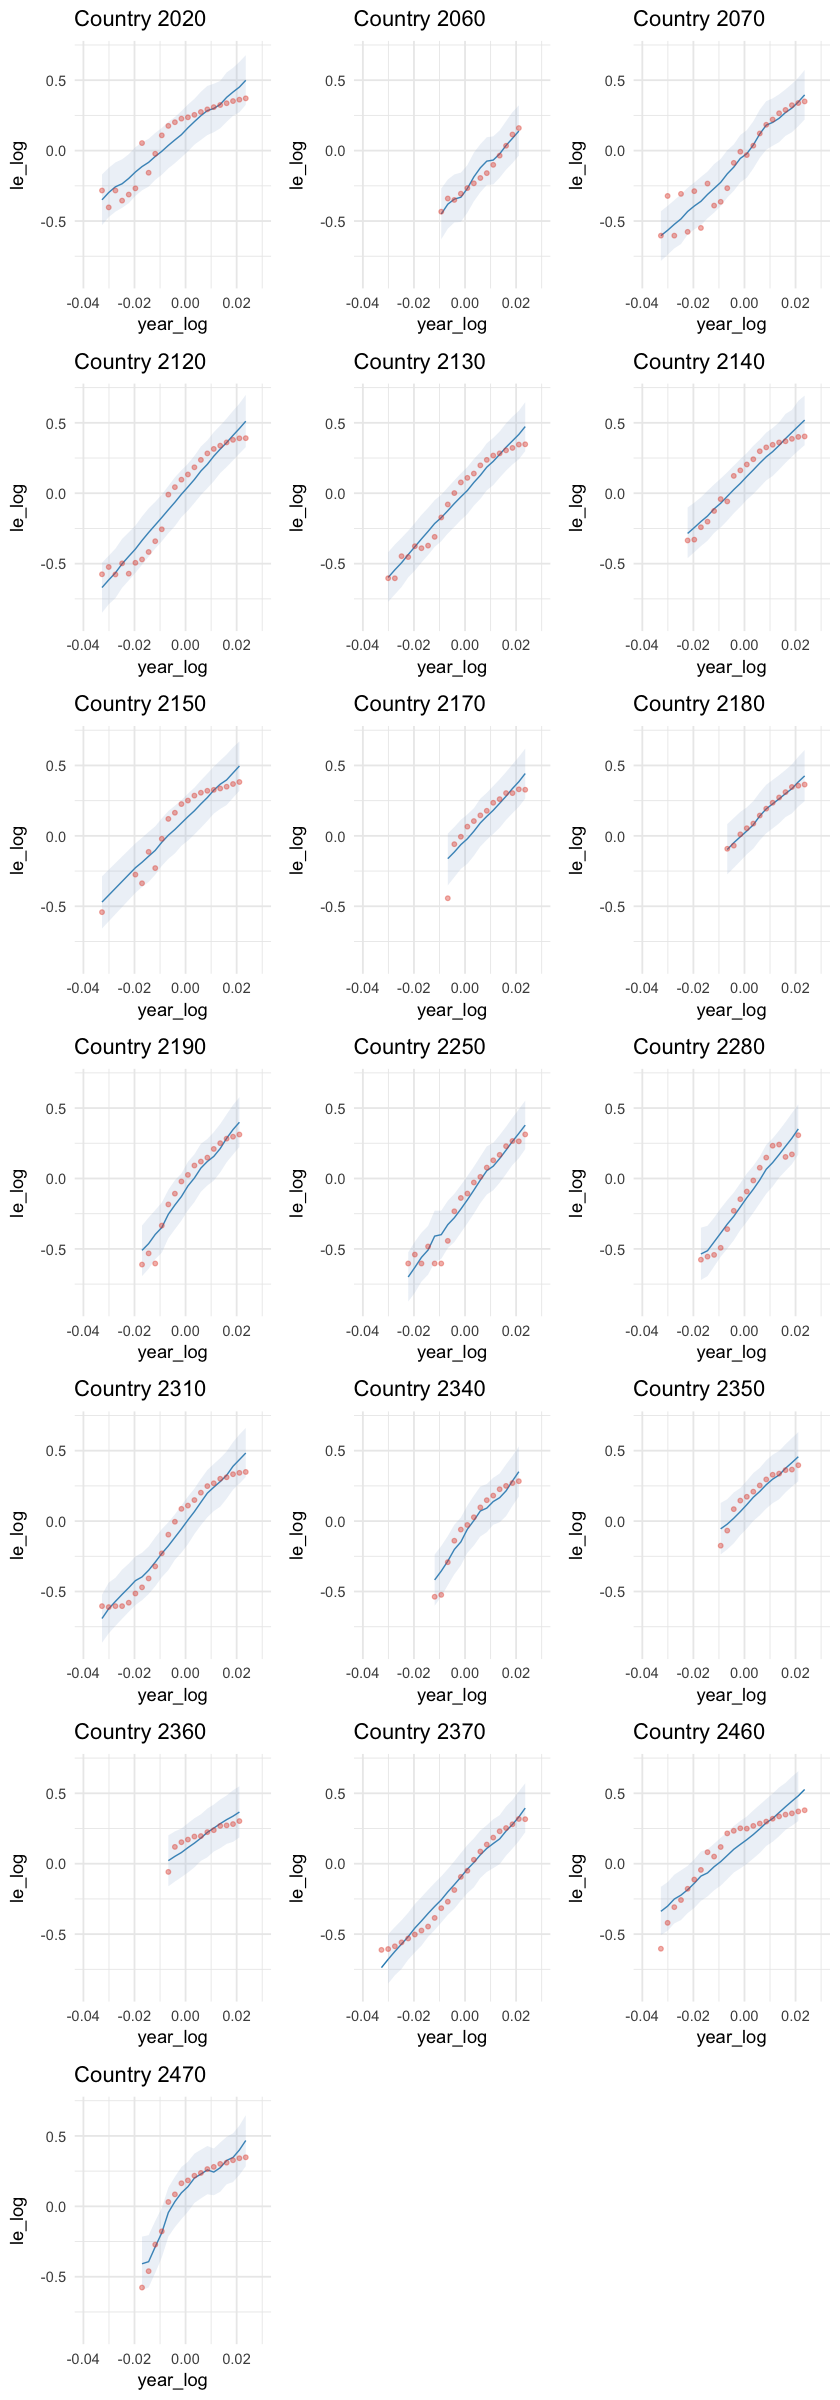

In [203]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))

# Random effects (Model 2)

In [204]:
re = ranef(m2) # get random effects

In [ ]:
re$ctry

In [205]:
re_year = re$ctry[, c(1,3,4), 1]
re_year = data.table(year= rownames(re_year), re_year)
setnames(re_year, names(re_year), c('country', 'm', 'lo', 'hi'))

In [206]:
setkey(re_year, m)

re_year[, country := as_factor(country)]

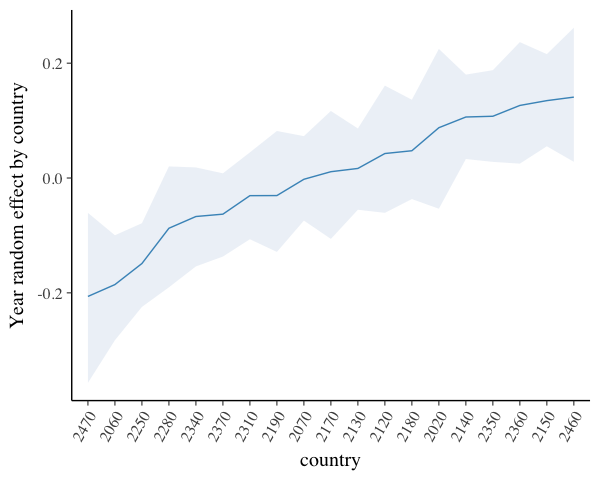

In [207]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_year, aes(x=country, y=m)) + 
geom_line(color='#2b8cbe', size = 0.4, group=1) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2, group=1) + 
   labs(y='Year random effect by country') + 
   theme(axis.text.x = element_text(angle = 60, hjust = 1))

In [212]:
re_gdp = re$ctry[, c(1,3,4), 2]
re_gdp  = data.table(country= rownames(re_gdp), re_gdp)
setnames(re_gdp, names(re_gdp), c('country', 'm', 'lo', 'hi'))

In [213]:
setkey(re_gdp, m)
re_gdp[, country := as_factor(country)]

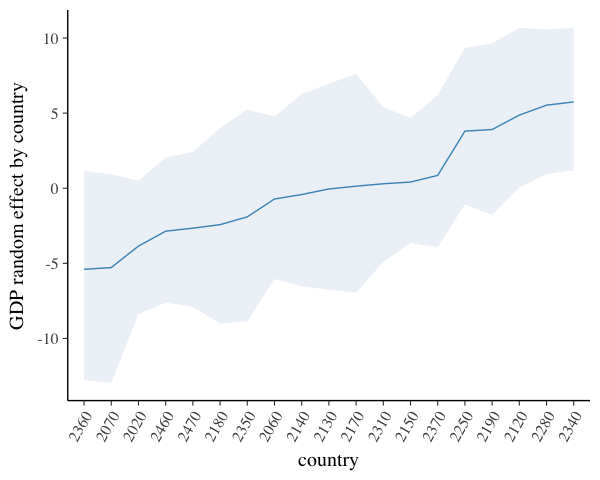

In [214]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot(re_gdp, aes(x=country, y=m)) + 
geom_line(color='#2b8cbe', size = 0.4, group=1) + 
   geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2, group=1) + 
   labs(y='GDP random effect by country') + 
   theme(axis.text.x = element_text(angle = 60, hjust = 1))

## INLA + Random Walk (same trend by country)

Random gdp term by country! Much much better fit... I have to figure out how to run this using stan, because here I use INLA. 

In [229]:
library(INLA)
library(brinla)

In [247]:
df[, ctry_gdp := ctry]

In [298]:
formula = le_log ~ gdp_log + f(year, model = 'rw2') +
    f(ctry, model = 'iid') + 
    f(ctry_gdp, gdp_log, model = 'iid')
    
m4 = inla(formula, 
          control.compute = list(dic = TRUE),
          family = 'gaussian', 
          data = df)

In [299]:
round(m4$summary.fixed, 3)

,mean,sd,0.025quant,0.5quant,0.975quant,mode,kld
(Intercept),-0.087,0.030,-0.146,-0.087,-0.029,-0.086,0
gdp_log,0.024,0.033,-0.042,0.024,0.090,0.023,0


In [300]:
bri.hyperpar.summary(m4)

,mean,sd,q0.025,q0.5,q0.975,mode
SD for the Gaussian observations,0.066602659,0.0027770034,0.061418226,0.066495596,0.072316919,0.066200947
SD for year,0.003416823,0.0006462102,0.002347259,0.003345358,0.004876336,0.003203015
SD for ctry,0.125275094,0.0218118849,0.089086024,0.122862025,0.174469333,0.117952307
SD for ctry_gdp,0.105691597,0.0222691295,0.069890148,0.102851036,0.156957096,0.097241815


### Plot predictions

In [301]:
fit = m4$summary.fitted.values
pred = data.table(df, m= fit$'0.5quant', lo = fit$'0.025quant', hi = fit$'0.975quant')

In [302]:
countries = unique(pred$ctry)

In [303]:
for (i in 1:length(countries)) {
    assign(paste0('plot', i), 
           ggplot(pred[ctry==countries[i]], aes(x=year, y=le_log)) + 
           geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
           geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
           geom_point(size=1, color='#e34a33', alpha=0.4) +
           labs(title=paste0('Country ',countries[i])) + 
           ylim(-0.9, 0.7) + 
           xlim(1889, 2011) +
           theme_minimal()
       )

}

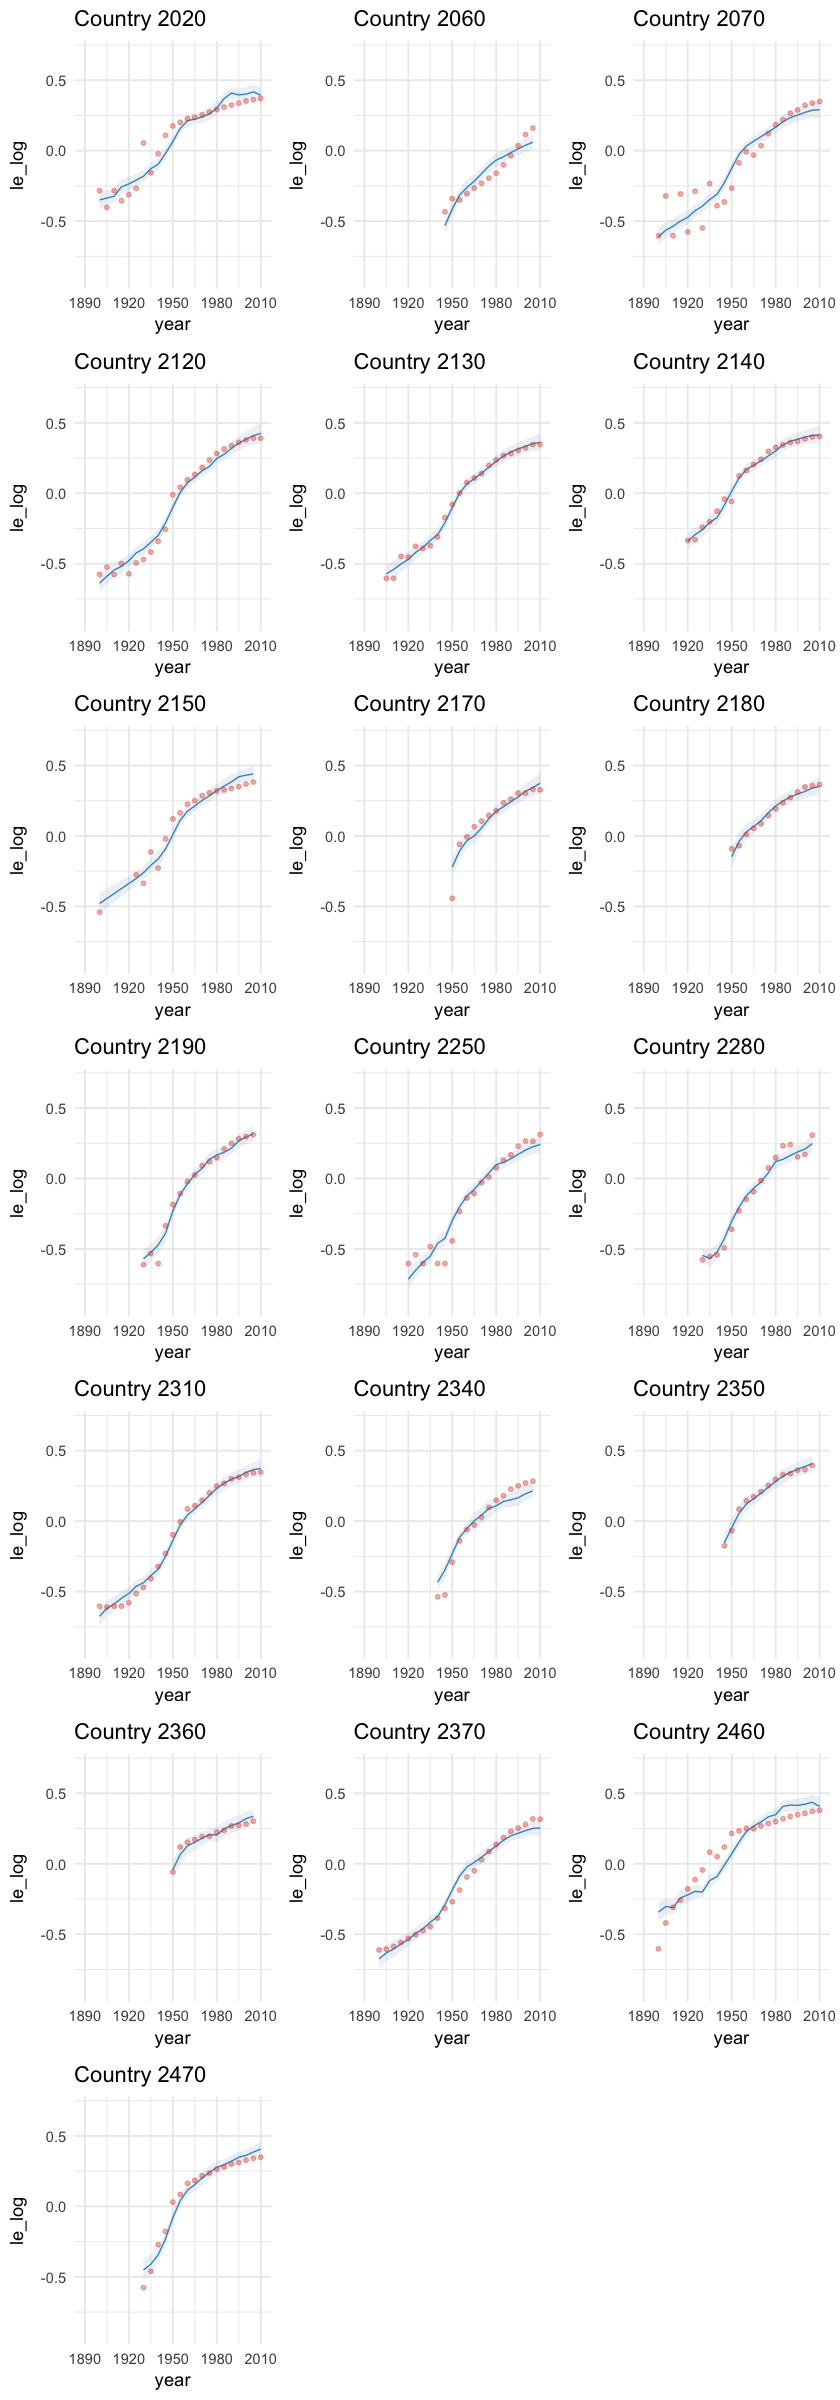

In [304]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(countries), collapse='+'), '+plot_layout(ncol = 3)')))